In [1]:
# Imports:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler,RobustScaler
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

from sklearn import metrics
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix,\
ConfusionMatrixDisplay, accuracy_score, RocCurveDisplay, roc_auc_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler 

from sklearn.cluster import KMeans

import lightgbm as lgb

import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

get_ipython().run_line_magic('matplotlib', 'inline')

pd.options.display.max_columns = None
pd.options.display.max_rows = None

import geopandas as gpd

In [2]:
# # steps to install geopandas

# !pip install pipwin
# !pipwin install gdal
# !pipwin install fiona
# !pip install geopandas
# !pipwin install rasterio
# !pip install contextily

In [3]:
# # install category_encoders if needed
# !pip install --upgrade category_encoders

In [4]:
#!pip install lightgbm
#!pip install imblearn

## Define function

In [5]:
def plot_geodata(dict_df):
    colors = ['black','red','orange','yellow']
    markersizes = [3, 14, 1, 5]
    zorders = [4,3,1,2]
    
    fig_, ax_ = plt.subplots(figsize=(20,20))
    
    # plot neighborhoods map of chicago
    geojson_file = './datasets/Boundary-community-area.geojson'
    neighborhoods = gpd.read_file(geojson_file)
    neighborhoods.plot(ax=ax_)
    
    # plot station
    # initialize list of lists
    list_station = [['1',  41.995,-87.933], ['2', 41.786,-87.752]]
    
    # Create the pandas DataFrame
    df_station = pd.DataFrame(list_station, columns=['Station', 'Latitude','Longitude'])
    gdf = gpd.GeoDataFrame(df_station, geometry=gpd.points_from_xy(df_station.Longitude, df_station.Latitude))
    gdf.plot(ax=ax_, color='purple', markersize=20,zorder=5, label="weather stations")
    
    i=0
    for label_df,df in dict_df.items():
        color_ = colors[i]
        markersize_ = markersizes[i]
        zorder_ = zorders[i]
        label_ = label_df

        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
        gdf.plot(ax=ax_, color=color_, markersize=markersize_,zorder=zorder_, label=label_)
        i += 1
        
    ax_.legend(loc='lower left', fontsize=12, markerscale=5)
    plt.show()
    return 

In [6]:
def get_weather_data(station =1, # station ID
                     flag = 1,  #1: shift, 2:rolling avg,  3: rolling max
                     feature =None, 
                     k=0 #day lag
                    ):
    if k == 0:
        if station == 1 :
            return df_weather_1[feature]
        else:
            return df_weather_2[feature]
    else:
        if flag == 1: # to shift
             if station == 1 :
                return df_weather_1[feature].shift(k).rename(columns={feature[0]:f'{feature[0]}-{k}'})
             else:
                return df_weather_2[feature].shift(k).rename(columns={feature[0]:f'{feature[0]}-{k}'})
        elif flag == 2: #to avg
             if station == 1 :
                return df_weather_1[feature].rolling(k).mean().rename(columns={feature[0]:f'{feature[0]}-avg-{k}'})
             else:
                return df_weather_2[feature].rolling(k).mean().rename(columns={feature[0]:f'{feature[0]}-avg-{k}'})
        elif flag == 3: #to max
             if station == 1 :
                return df_weather_1[feature].rolling(k).max().rename(columns={feature[0]:f'{feature[0]}-max-{k}'})
             else:
                return df_weather_2[feature].rolling(k).max().rename(columns={feature[0]:f'{feature[0]}-max-{k}'})

In [7]:
def add_weather_features(df, 
                         weather_features_shift=None,
                         weather_features_avg=None,
                         weather_features_max=None
                        ):
    df['id_'] = df.index
    df1 = df.query("Station==1")
    df2 = df.query("Station==2")
    
    features_numeric_weather = ["Tmax","Tmin","Tavg",'DewPoint',"Sunrise",
                                 "Sunset",'Day_length','PrecipTotal','ResultSpeed']                       
                             
    df1 = pd.merge(df1, df_weather_1[features_numeric_weather],on='Date',how='inner')
    df2 = pd.merge(df2, df_weather_2[features_numeric_weather],on='Date',how='inner')
    
    #pd.merge(product,customer,on='Product_ID',how='left')
    for key, value in weather_features_shift.items():
        result_feature_column_1 = get_weather_data(1,1,[key],value)
        df1 = pd.merge(df1,result_feature_column_1,on='Date',how='inner')
        
        result_feature_column_2 = get_weather_data(2,1,[key],value)
        df2 = pd.merge(df2,result_feature_column_2,on='Date',how='inner')
  
    for key, value in weather_features_avg.items():
        result_feature_column_1 = get_weather_data(1,2,[key],value)
        df1 = pd.merge(df1,result_feature_column_1,on='Date',how='inner')
        
        result_feature_column_2 = get_weather_data(2,2,[key],value)
        df2 = pd.merge(df2,result_feature_column_2,on='Date',how='inner')
  

    for key, value in weather_features_max.items():
        result_feature_column_1 = get_weather_data(1,3,[key],value)
        df1 = pd.merge(df1,result_feature_column_1,on='Date',how='inner')
        
        result_feature_column_2 = get_weather_data(2,3,[key],value)
        df2 = pd.merge(df2,result_feature_column_2,on='Date',how='inner')
  


    df_final = pd.concat([df1, df2], sort=False)
    df_final.set_index('id_', drop=True, inplace=True)
    df_final.sort_index(inplace=True)

    return  df_final

In [8]:
# copy from https://www.geeksforgeeks.org/program-distance-two-points-earth/#:~:text=For%20this%20divide%20the%20values,is%20the%20radius%20of%20Earth.
# Python 3 program to calculate Distance Between Two Points on Earth
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lat2, lon1, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)
     

In [9]:
def near_station(row):
    lat = row['Latitude']
    lon = row['Longitude']
    station1_lat = 41.995
    station1_lon =  -87.933
    station2_lat =  41.786
    station2_lon = -87.752
    
    if distance(lat, station1_lat, lon, station1_lon) < distance(lat, station2_lat, lon, station2_lon):
        return 1
    else:
        return 2

In [10]:
#The function will:
# 1. run the input GridSearchCV
# 2. compute and compare the roc_auc_score, accuracy score for training data and testing data
# 3. get and print the confusion matrix
# 4. plot the confusion matrix and ROC curve

def run_model(gs, X_train, y_train, X_test, y_test ):
    
    # run the input GridSearchCV
    gs.fit(X_train, y_train)
    
    print("best_params: ")
   # print(gs.best_params_)
    for (item, value) in gs.best_params_.items():
        print('   ',item, ' : ', value)
    
    #compute and compare the auc_score for training data and testing data
    train_auc_score = gs.score(X_train, y_train)
    test_auc_score = gs.score(X_test, y_test)
    auc_perc_diff = np.abs(test_auc_score/train_auc_score*100-100)
    
    print(f'\nroc_auc_score on training set: {train_auc_score:.3f}')
    print(f'roc_auc_score on testing set: {test_auc_score:.3f}')
    print(f'perc_diff: {auc_perc_diff:.1f} %\n')
    
    # Get predictions
    y_train_preds = gs.predict(X_train) 
    y_test_preds = gs.predict(X_test)
    
    #calculate the accuracy_score
    train_f1_score =  f1_score(y_train, y_train_preds)
    test_f1_score = f1_score(y_test, y_test_preds)
    f1_perc_diff = np.abs(test_f1_score/train_f1_score*100-100)
    print(f'\nf1_score on training set: {train_f1_score:.3f}')
    print(f'f1_score on testing set: {test_f1_score:.3f}')
    print(f'perc_diff: {f1_perc_diff:.1f} %\n')
    
    
    
    # Save confusion matrix values
    print("confusion matrix: ")
    cm = confusion_matrix(y_test, y_test_preds)
    cm_df = pd.DataFrame(cm, columns=['pred No virus', 'pred WnvPresent'], 
                         index=['actual No virus', 'actual WnvPresent'])
    print(cm_df.head())
                    
        
    print("\nplot confusion matrix and ROC curve")
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=[10,5])
    
    # View confusion matrix
    ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, ax=ax1)
    ax1.set_title("confusion matrix")
    
    #plot ROC curve
    RocCurveDisplay.from_estimator(gs, X_test, y_test,ax=ax2) 
    
    
    #plot featureimportances
    model = gs.best_estimator_.named_steps["classifier"]
    importances = model.feature_importances_
    indices = np.argsort(importances)
    fig,ax=plt.subplots(1,figsize=(10,16))
    features = X_train.columns
    plt.title('Feature Importances')
    ax.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

## Date Import and Cleaning

In [11]:
df_train = pd.read_csv("./datasets/train.csv")

In [12]:
df_train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.99,-87.77,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.97,-87.82,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.97,-87.82,8,4,0


In [13]:
df_train.Species.value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [14]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Block,"10,506.00",35.69,24.34,10.00,12.00,33.00,52.00,98.00
Latitude,"10,506.00",41.84,0.11,41.64,41.73,41.85,41.95,42.02
Longitude,"10,506.00",-87.70,0.10,-87.93,-87.76,-87.69,-87.63,-87.53
AddressAccuracy,"10,506.00",7.82,1.45,3.00,8.00,8.00,9.00,9.00
NumMosquitos,"10,506.00",12.85,16.13,1.00,2.00,5.00,17.00,50.00
WnvPresent,"10,506.00",0.05,0.22,0.00,0.00,0.00,0.00,1.00


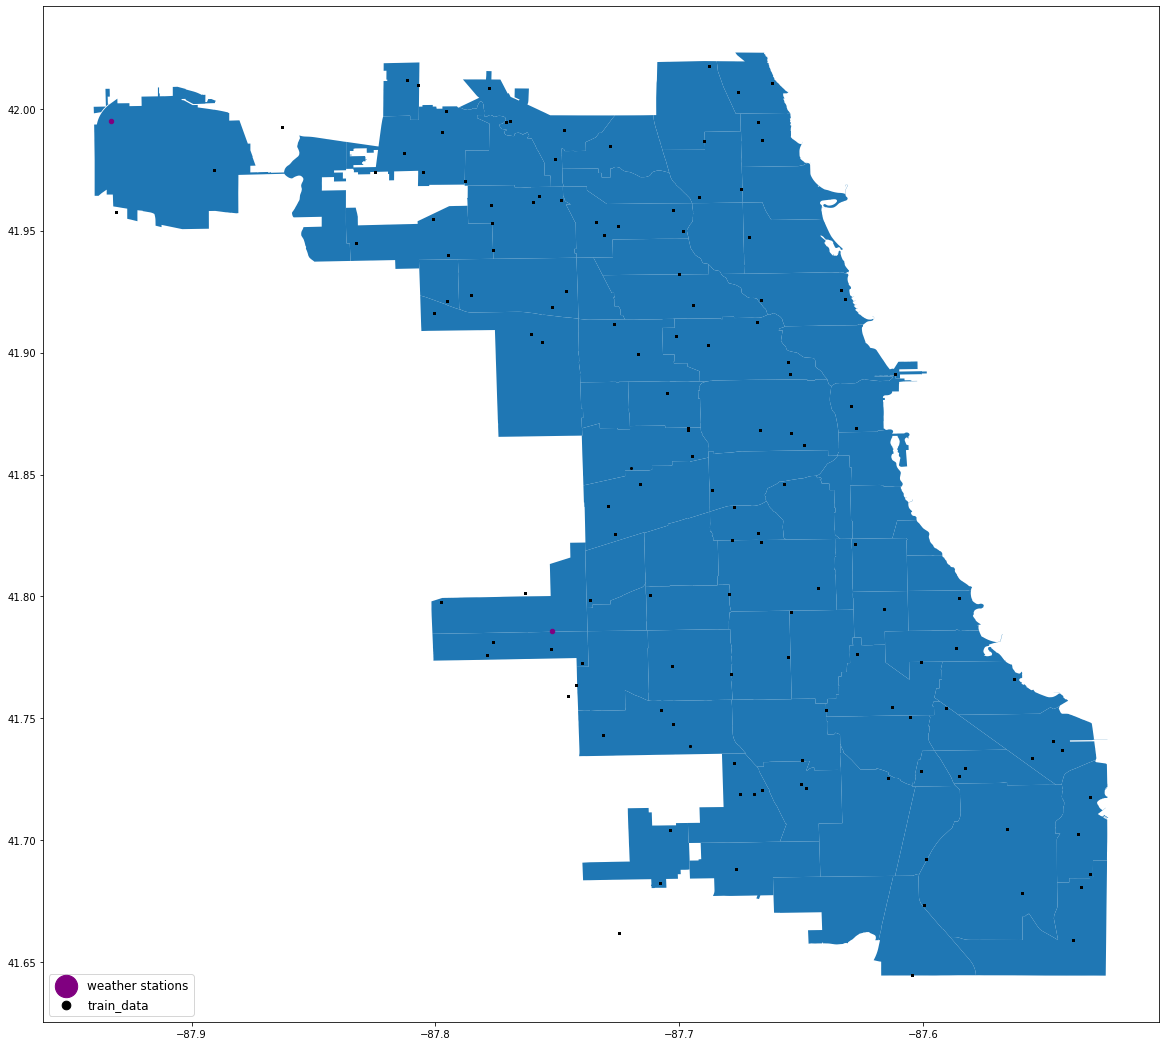

In [15]:
# plot data to the map
dict_df = {'train_data': df_train}
plot_geodata(dict_df)

In [16]:
df_test = pd.read_csv("./datasets/test.csv")
df_test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95,-87.80,9


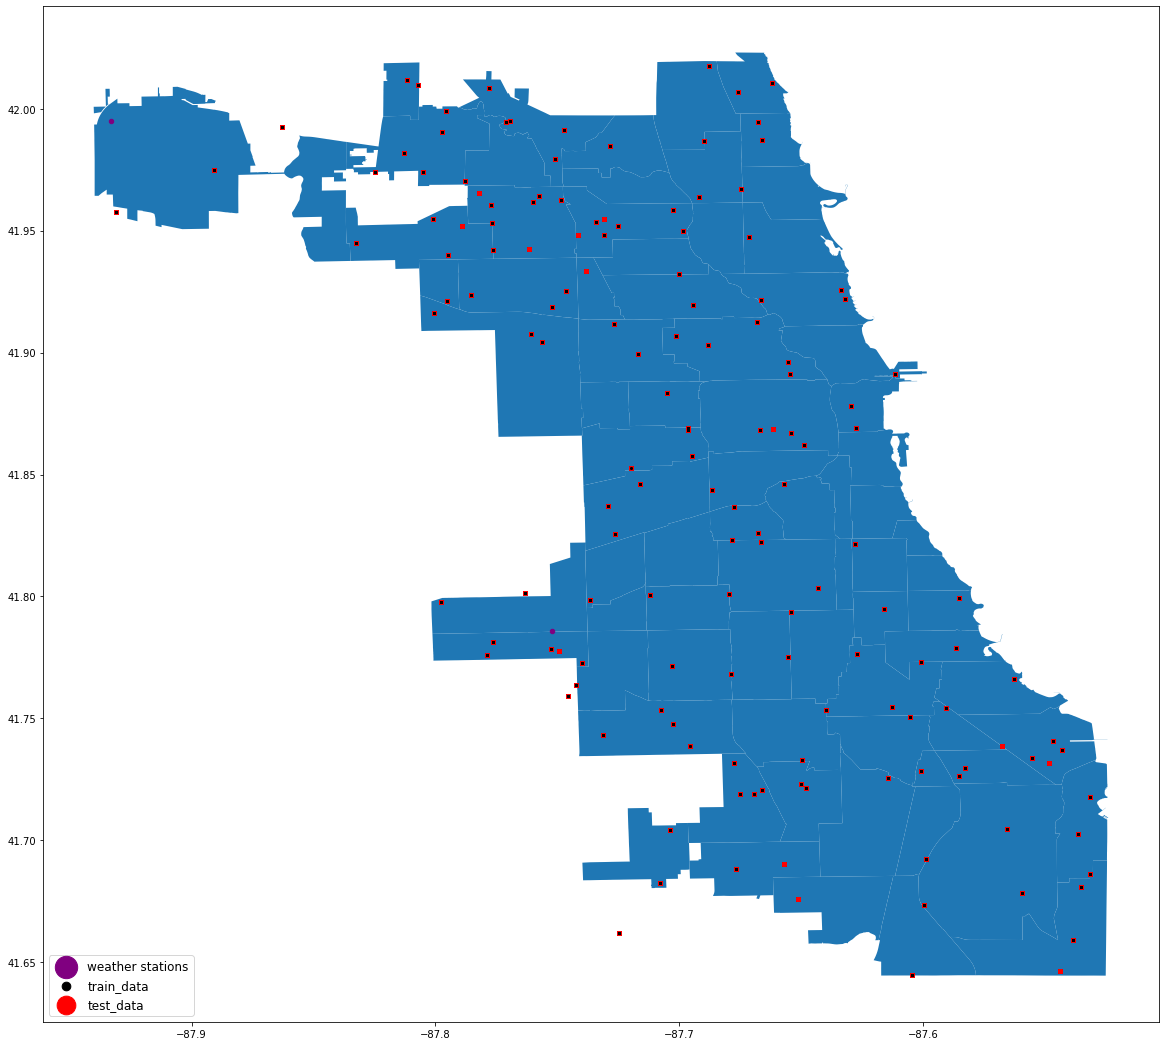

In [17]:
dict_df = {'train_data':df_train, 
           'test_data':df_test,
          }
plot_geodata(dict_df)